Business Understanding

Data Understanding

Data Preperation

Modeling

Evaluation

Business Question:

Predicting who is likely to have the h1n1 vaccines to know where to prepare support (money, vaccines, medical attention) in the case of a new outbreak.

Outbreak of viruses thought to be almost eradicated are beginning to pop up again, as an example measles.

In [73]:
# Import libraries

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer,  make_column_selector as selector
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB

from sklearn.metrics import plot_confusion_matrix, recall_score,\
    accuracy_score, precision_score, f1_score

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline

from sklearn.dummy import DummyClassifier

In [2]:
# Set Options

pd.set_option('max_columns', None)
sns.set_palette("colorblind")

In [3]:
# Read in csv

df = pd.read_csv('data/training_set_features.csv')
df_tars = pd.read_csv('data/training_set_labels.csv')

df_tars.head()

,respondent_id,h1n1_vaccine,seasonal_vaccine
0,0,0,0
1,1,0,1
2,2,0,0
3,3,0,1
4,4,0,0


In [4]:
df = df.join(df_tars, on='respondent_id', rsuffix='_tars')

In [5]:
df.shape

(26707, 39)

In [6]:
df.head()

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,respondent_id_tars,h1n1_vaccine,seasonal_vaccine
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,2.0,2.0,1.0,2.0,55 - 64 Years,< 12 Years,White,Female,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN,0,0,0
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,4.0,4.0,4.0,2.0,4.0,35 - 44 Years,12 Years,White,Male,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe,1,0,1
2,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,0.0,0.0,NaN,3.0,1.0,1.0,4.0,1.0,2.0,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo,2,0,0
3,3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,NaN,3.0,3.0,5.0,5.0,4.0,1.0,65+ Years,12 Years,White,Female,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN,3,0,1
4,4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,3.0,3.0,2.0,3.0,1.0,4.0,45 - 54 Years,Some College,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb,4,0,0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26707 entries, 0 to 26706
Data columns (total 39 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   respondent_id                26707 non-null  int64  
 1   h1n1_concern                 26615 non-null  float64
 2   h1n1_knowledge               26591 non-null  float64
 3   behavioral_antiviral_meds    26636 non-null  float64
 4   behavioral_avoidance         26499 non-null  float64
 5   behavioral_face_mask         26688 non-null  float64
 6   behavioral_wash_hands        26665 non-null  float64
 7   behavioral_large_gatherings  26620 non-null  float64
 8   behavioral_outside_home      26625 non-null  float64
 9   behavioral_touch_face        26579 non-null  float64
 10  doctor_recc_h1n1             24547 non-null  float64
 11  doctor_recc_seasonal         24547 non-null  float64
 12  chronic_med_condition        25736 non-null  float64
 13  child_under_6_mo

In [8]:
df.describe()

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,household_adults,household_children,respondent_id_tars,h1n1_vaccine,seasonal_vaccine
count,26707.000000,26615.000000,26591.000000,26636.000000,26499.000000,26688.000000,26665.000000,26620.00000,26625.000000,26579.000000,24547.000000,24547.000000,25736.000000,25887.000000,25903.000000,14433.00000,26316.000000,26319.000000,26312.000000,26245.000000,26193.000000,26170.000000,26458.000000,26458.000000,26707.000000,26707.000000,26707.000000
mean,13353.000000,1.618486,1.262532,0.048844,0.725612,0.068982,0.825614,0.35864,0.337315,0.677264,0.220312,0.329735,0.283261,0.082590,0.111918,0.87972,3.850623,2.342566,2.357670,4.025986,2.719162,2.118112,0.886499,0.534583,13353.000000,0.212454,0.465608
std,7709.791156,0.910311,0.618149,0.215545,0.446214,0.253429,0.379448,0.47961,0.472802,0.467531,0.414466,0.470126,0.450591,0.275266,0.315271,0.32530,1.007436,1.285539,1.362766,1.086565,1.385055,1.332950,0.753422,0.928173,7709.791156,0.409052,0.498825
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6676.500000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.00000,3.000000,1.000000,1.000000,4.000000,2.000000,1.000000,0.000000,0.000000,6676.500000,0.000000,0.000000
50%,13353.000000,2.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.00000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.00000,4.000000,2.000000,2.000000,4.000000,2.000000,2.000000,1.000000,0.000000,13353.000000,0.000000,0.000000
75%,20029.500000,2.000000,2.000000,0.000000,1.000000,0.000000,1.000000,1.00000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.00000,5.000000,4.000000,4.000000,5.000000,4.000000,4.000000,1.000000,1.000000,20029.500000,0.000000,1.000000
max,26706.000000,3.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,3.000000,3.000000,26706.000000,1.000000,1.000000


In [9]:
df.select_dtypes(include='object').describe()

,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,employment_industry,employment_occupation
count,26707,25300,26707,26707,22284,25299,24665,25244,26707,26707,13377,13237
unique,5,4,4,2,3,2,2,3,10,3,21,23
top,65+ Years,College Graduate,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,lzgpxyit,"MSA, Not Principle City",fcxhlnwr,xtkaffoo
freq,6843,10097,21222,15858,12777,13555,18736,13560,4297,11645,2468,1778


In [80]:
df.loc[:, ['respondent_id', 'respondent_id_tars']]

,respondent_id,respondent_id_tars
0,0,0
1,1,1
2,2,2
3,3,3
4,4,4
...,...,...
26702,26702,26702
26703,26703,26703
26704,26704,26704
26705,26705,26705


In [85]:
# Identifier
cols_ident = df.loc[:, ['respondent_id', 'respondent_id_tars']] 

# Numerical
cols_num = df.loc[:, ['household_adults', 'household_children',
                        'behavioral_antiviral_meds', 'behavioral_avoidance',
                        'behavioral_face_mask', 'behavioral_wash_hands',
                        'behavioral_large_gatherings', 'behavioral_outside_home', 
                        'behavioral_touch_face', 'doctor_recc_h1n1', 
                        'doctor_recc_seasonal', 'chronic_med_condition', 
                        'child_under_6_months', 'health_worker', 
                        'health_insurance']]

# # Binary
# cols_bina = df.loc[:, ['behavioral_antiviral_meds', 'behavioral_avoidance',
#             'behavioral_face_mask', 'behavioral_wash_hands',
#             'behavioral_large_gatherings', 'behavioral_outside_home', 
#             'behavioral_touch_face', 'doctor_recc_h1n1', 
#             'doctor_recc_seasonal', 'chronic_med_condition', 
#             'child_under_6_months', 'health_worker', 
#             'health_insurance']]

# All Numbers


# Categorical
cols_cats = df.loc[:, ['age_group', 'education', 'race', 'sex', 'income_poverty', 
             'marital_status', 'rent_or_own', 'employment_status', 
             'hhs_geo_region', 'census_msa', 'employment_industry', 
             'employment_occupation']]

# Ordinal
cols_ords = df.loc[:, ['h1n1_concern', 'h1n1_knowledge', 
            'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk', 
            'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective', 
            'opinion_seas_risk', 'opinion_seas_sick_from_vacc']]

In [83]:
cols_ident

,respondent_id,respondent_id_tars
0,0,0
1,1,1
2,2,2
3,3,3
4,4,4
...,...,...
26702,26702,26702
26703,26703,26703
26704,26704,26704
26705,26705,26705


0    0.787546
1    0.212454
Name: h1n1_vaccine, dtype: float64


[Text(0, 0, 'No H1N1 Vax'), Text(1, 0, 'H1N1 Vax')]

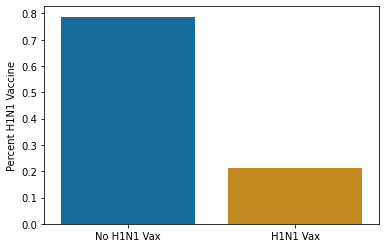

In [12]:
# Look at the proportion of respondents who have recieved the H1N1 Vaccine

# Get Proportions
vax_prop = df.h1n1_vaccine.value_counts(normalize=True)
print(vax_prop)


# Chart
fig, ax = plt.subplots()

sns.barplot(x=vax_prop.index, y=vax_prop.values)

ax.set_xlabel('')
ax.set_ylabel('Percent H1N1 Vaccine')

ax.set_xticklabels(['No H1N1 Vax', 'H1N1 Vax'])

18 - 34 Years    0.190029
35 - 44 Years    0.197765
45 - 54 Years    0.194731
55 - 64 Years    0.242855
65+ Years        0.226655
dtype: float64


Text(0, 0.5, 'Percent H1N1 Vaccine')

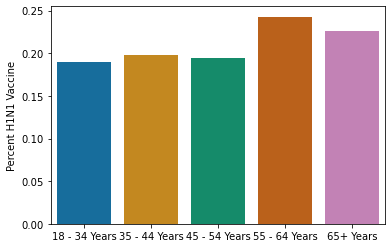

In [15]:
# H1N1 vaccination percenta by age group

# Count of H1N1 vaccinations by age group
df.groupby('age_group').sum().h1n1_vaccine

#Count of age group interviewed
df.age_group.value_counts()

# Calculate percent of H1N1 vaccination by age group
per_h1_age = df.groupby('age_group').sum().h1n1_vaccine / df.age_group.value_counts()
print(per_h1_age)

fig, ax = plt.subplots()

sns.barplot(x=per_h1_age.index, y=per_h1_age.values)

ax.set_xlabel('')
ax.set_ylabel('Percent H1N1 Vaccine')

In [47]:
#Proportions for numerical
h1n1_rates_house_adlts = df.groupby('household_adults').mean().h1n1_vaccine
h1n1_rates_house_child = df.groupby('household_children').mean().h1n1_vaccine

print(h1n1_rates_house_adlts, '\n')
print(h1n1_rates_house_child, '\n')

h1n1_rates_for_bar_numerical = [h1n1_rates_house_adlts, h1n1_rates_house_child]

#Proportions for Binary

h1n1_rates_beh_virmeds = df.groupby('behavioral_antiviral_meds').mean().h1n1_vaccine
h1n1_rates_beh_avoid = df.groupby('behavioral_avoidance').mean().h1n1_vaccine

h1n1_rates_beh_facemask = df.groupby('behavioral_face_mask').mean().h1n1_vaccine
h1n1_rates_beh_washhands = df.groupby('behavioral_wash_hands').mean().h1n1_vaccine

h1n1_rates_beh_gatherings = df.groupby('behavioral_large_gatherings').mean().h1n1_vaccine
h1n1_rates_beh_outside = df.groupby('behavioral_outside_home').mean().h1n1_vaccine

h1n1_rates_beh_touchface = df.groupby('behavioral_touch_face').mean().h1n1_vaccine
h1n1_rates_docrec = df.groupby('doctor_recc_h1n1').mean().h1n1_vaccine

h1n1_rates_chroncond = df.groupby('chronic_med_condition').mean().h1n1_vaccine
h1n1_rates_childund6 = df.groupby('child_under_6_months').mean().h1n1_vaccine

h1n1_rates_healthworker = df.groupby('health_worker').mean().h1n1_vaccine
h1n1_rates_insurance = df.groupby('health_insurance').mean().h1n1_vaccine

print(h1n1_rates_insurance, '\n')
print(h1n1_rates_beh_avoid, '\n')
print(h1n1_rates_beh_facemask, '\n')
print(h1n1_rates_beh_washhands, '\n')
print(h1n1_rates_beh_gatherings, '\n')
print(h1n1_rates_beh_outside, '\n')
print(h1n1_rates_beh_touchface, '\n')
print(h1n1_rates_docrec, '\n')
print(h1n1_rates_chroncond, '\n')
print(h1n1_rates_childund6, '\n')
print(h1n1_rates_healthworker, '\n')
print(h1n1_rates_insurance, '\n')

h1n1_rates_for_bar_binary = [h1n1_rates_beh_virmeds,
h1n1_rates_beh_avoid,
h1n1_rates_beh_facemask,
h1n1_rates_beh_washhands,
h1n1_rates_beh_gatherings,
h1n1_rates_beh_outside,
h1n1_rates_beh_touchface,
h1n1_rates_docrec,
h1n1_rates_chroncond,
h1n1_rates_childund6,
h1n1_rates_healthworker,
h1n1_rates_insurance]

# Proportions for categoricals
h1n1_rates_age = df.groupby('age_group').mean().h1n1_vaccine
print(h1n1_rates_age, '\n')
h1n1_rates_education = df.groupby('education').mean().h1n1_vaccine
print(h1n1_rates_education)
h1n1_rates_race = df.groupby('race').mean().h1n1_vaccine
print(h1n1_rates_race, '\n')
h1n1_rates_sex = df.groupby('sex').mean().h1n1_vaccine
print(h1n1_rates_sex, '\n')
h1n1_rates_income = df.groupby('income_poverty').mean().h1n1_vaccine
print(h1n1_rates_income, '\n')
h1n1_rates_marital = df.groupby('marital_status').mean().h1n1_vaccine
print(h1n1_rates_marital, '\n')
h1n1_rates_own = df.groupby('rent_or_own').mean().h1n1_vaccine
print(h1n1_rates_own, '\n')
h1n1_rates_employment_status = df.groupby('employment_status').mean().h1n1_vaccine
print(h1n1_rates_employment_status, '\n')
h1n1_rates_geo = df.groupby('hhs_geo_region').mean().h1n1_vaccine.sort_values(ascending=False)
print(h1n1_rates_geo, '\n')
h1n1_rates_census = df.groupby('census_msa').mean().h1n1_vaccine
print(h1n1_rates_census, '\n')
h1n1_rates_employment_industry = df.groupby('employment_industry').mean().h1n1_vaccine.sort_values(ascending=False)
print(h1n1_rates_employment_industry, '\n')
h1n1_rates_employment_occupation = df.groupby('employment_occupation').mean().h1n1_vaccine.sort_values(ascending=False)
print(h1n1_rates_employment_occupation)


h1n1_rates_for_bar_cat = [h1n1_rates_age, h1n1_rates_education,
                         h1n1_rates_race, h1n1_rates_sex,
                         h1n1_rates_income, h1n1_rates_marital,
                         h1n1_rates_own, h1n1_rates_employment_status,
                         h1n1_rates_geo, h1n1_rates_census,
                         h1n1_rates_employment_industry, h1n1_rates_employment_occupation]


# Proportions for ordinals
h1n1_rates_houseadlt = df.groupby('household_adults').mean().h1n1_vaccine
h1n1_rates_housechld = df.groupby('household_children').mean().h1n1_vaccine
print(h1n1_rates_houseadlt, '\n')
print(h1n1_rates_housechld, '\n')

h1n1_rates_concern = df.groupby('h1n1_concern').mean().h1n1_vaccine
h1n1_rates_knowledge = df.groupby('h1n1_knowledge').mean().h1n1_vaccine
print(h1n1_rates_concern, '\n')
print(h1n1_rates_knowledge, '\n')

h1n1_rates_op_effective = df.groupby('opinion_h1n1_vacc_effective').mean().h1n1_vaccine
h1n1_rates_op_risk = df.groupby('opinion_h1n1_risk').mean().h1n1_vaccine
h1n1_rates_op_sickfromvac = df.groupby('opinion_h1n1_sick_from_vacc').mean().h1n1_vaccine
print(h1n1_rates_op_affective, '\n')
print(h1n1_rates_op_risk, '\n')
print(h1n1_rates_op_sickfromvac, '\n')

h1n1_rates_for_bar_ord = [h1n1_rates_houseadlt, h1n1_rates_housechld, 
                      h1n1_rates_concern, h1n1_rates_knowledge, 
                      h1n1_rates_op_effective, h1n1_rates_op_risk,
                      h1n1_rates_op_sickfromvac]

household_adults
0.0    0.196748
1.0    0.225577
2.0    0.200856
3.0    0.197333
Name: h1n1_vaccine, dtype: float64 

household_children
0.0    0.213314
1.0    0.212283
2.0    0.219623
3.0    0.199771
Name: h1n1_vaccine, dtype: float64 

health_insurance
0.0    0.147465
1.0    0.317713
Name: h1n1_vaccine, dtype: float64 

behavioral_avoidance
0.0    0.181131
1.0    0.224880
Name: h1n1_vaccine, dtype: float64 

behavioral_face_mask
0.0    0.204532
1.0    0.318305
Name: h1n1_vaccine, dtype: float64 

behavioral_wash_hands
0.0    0.146022
1.0    0.226573
Name: h1n1_vaccine, dtype: float64 

behavioral_large_gatherings
0.0    0.207169
1.0    0.222374
Name: h1n1_vaccine, dtype: float64 

behavioral_outside_home
0.0    0.206302
1.0    0.225142
Name: h1n1_vaccine, dtype: float64 

behavioral_touch_face
0.0    0.170319
1.0    0.233043
Name: h1n1_vaccine, dtype: float64 

doctor_recc_h1n1
0.0    0.136371
1.0    0.532359
Name: h1n1_vaccine, dtype: float64 

chronic_med_condition
0.0    0.188876


NameError: name 'h1n1_rates_op_affective' is not defined

In [48]:
for i in h1n1_rates_for_bar_numerical:
    print(i, ': ', i.max() - i.min(), '\n')

household_adults
0.0    0.196748
1.0    0.225577
2.0    0.200856
3.0    0.197333
Name: h1n1_vaccine, dtype: float64 :  0.0288291308635599 

household_children
0.0    0.213314
1.0    0.212283
2.0    0.219623
3.0    0.199771
Name: h1n1_vaccine, dtype: float64 :  0.019851868966112712 



In [49]:
for i in h1n1_rates_for_bar_binary:
    print(i, ': ', i.max() - i.min(), '\n')

behavioral_antiviral_meds
0.0    0.208171
1.0    0.285165
Name: h1n1_vaccine, dtype: float64 :  0.07699474239654427 

behavioral_avoidance
0.0    0.181131
1.0    0.224880
Name: h1n1_vaccine, dtype: float64 :  0.0437498642769763 

behavioral_face_mask
0.0    0.204532
1.0    0.318305
Name: h1n1_vaccine, dtype: float64 :  0.11377353466222515 

behavioral_wash_hands
0.0    0.146022
1.0    0.226573
Name: h1n1_vaccine, dtype: float64 :  0.08055128590232954 

behavioral_large_gatherings
0.0    0.207169
1.0    0.222374
Name: h1n1_vaccine, dtype: float64 :  0.015204305928348594 

behavioral_outside_home
0.0    0.206302
1.0    0.225142
Name: h1n1_vaccine, dtype: float64 :  0.018839540619657758 

behavioral_touch_face
0.0    0.170319
1.0    0.233043
Name: h1n1_vaccine, dtype: float64 :  0.06272318696732074 

doctor_recc_h1n1
0.0    0.136371
1.0    0.532359
Name: h1n1_vaccine, dtype: float64 :  0.39598870618282755 

chronic_med_condition
0.0    0.188876
1.0    0.275446
Name: h1n1_vaccine, dtype: f

In [50]:
for i in h1n1_rates_for_bar_cat:
    print(i, ': ', i.max() - i.min(), '\n')

age_group
18 - 34 Years    0.190029
35 - 44 Years    0.197765
45 - 54 Years    0.194731
55 - 64 Years    0.242855
65+ Years        0.226655
Name: h1n1_vaccine, dtype: float64 :  0.05282581168654904 

education
12 Years            0.184751
< 12 Years          0.167160
College Graduate    0.245915
Some College        0.207866
Name: h1n1_vaccine, dtype: float64 :  0.07875423877176826 

race
Black                0.148725
Hispanic             0.207977
Other or Multiple    0.216501
White                0.218877
Name: h1n1_vaccine, dtype: float64 :  0.07015142498711185 

sex
Female    0.219448
Male      0.202231
Name: h1n1_vaccine, dtype: float64 :  0.01721697709349479 

income_poverty
<= $75,000, Above Poverty    0.203412
> $75,000                    0.253010
Below Poverty                0.191324
Name: h1n1_vaccine, dtype: float64 :  0.06168658600925486 

marital_status
Married        0.233714
Not Married    0.191587
Name: h1n1_vaccine, dtype: float64 :  0.042127303035267544 

rent_or_own
Ow

In [51]:
h1n1_rates_for_bar_ord = [h1n1_rates_houseadlt, h1n1_rates_housechld, 
                      h1n1_rates_concern, h1n1_rates_knowledge, 
                      h1n1_rates_op_effective, h1n1_rates_op_risk,
                      h1n1_rates_op_sickfromvac]

In [52]:
for i in h1n1_rates_for_bar_ord:
    print(i, ': ', i.max() - i.min(), '\n')

household_adults
0.0    0.196748
1.0    0.225577
2.0    0.200856
3.0    0.197333
Name: h1n1_vaccine, dtype: float64 :  0.0288291308635599 

household_children
0.0    0.213314
1.0    0.212283
2.0    0.219623
3.0    0.199771
Name: h1n1_vaccine, dtype: float64 :  0.019851868966112712 

h1n1_concern
0.0    0.135619
1.0    0.171348
2.0    0.233853
3.0    0.292093
Name: h1n1_vaccine, dtype: float64 :  0.15647429383788036 

h1n1_knowledge
0.0    0.144054
1.0    0.181737
2.0    0.278065
Name: h1n1_vaccine, dtype: float64 :  0.13401045039076026 

opinion_h1n1_vacc_effective
1.0    0.047404
2.0    0.051130
3.0    0.105653
4.0    0.176410
5.0    0.404828
Name: h1n1_vaccine, dtype: float64 :  0.35742429292073363 

opinion_h1n1_risk
1.0    0.088340
2.0    0.167960
3.0    0.173679
4.0    0.392102
5.0    0.510857
Name: h1n1_vaccine, dtype: float64 :  0.42251705193688244 

opinion_h1n1_sick_from_vacc
1.0    0.204601
2.0    0.173184
3.0    0.081081
4.0    0.264274
5.0    0.280293
Name: h1n1_vaccine, dt

[Text(0, 0, 'Very Low'),
 Text(1, 0, 'Somewhat low'),
 Text(2, 0, "Don't know"),
 Text(3, 0, 'Somewhat high'),
 Text(4, 0, 'Very high')]

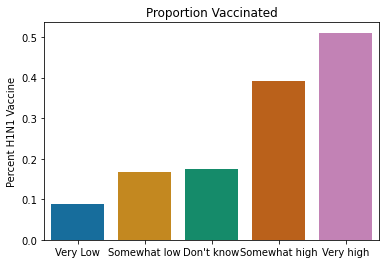

In [71]:
# Visualize proportion of level of respons opinion about risk of getting sick with H1N1 flu without vaccine with H1N1 vaccination

fig, ax = plt.subplots()

sns.barplot(x=h1n1_rates_op_risk.index, y=h1n1_rates_op_risk.values)

ax.set_xlabel('')
ax.set_ylabel('Percent H1N1 Vaccine')
ax.set_title('Proportion Vaccinated')

ax.set_xticklabels(['Very Low', 'Somewhat low', "Don't know", 'Somewhat high', 'Very high'])

[Text(0, 0, 'Not at all effective'),
 Text(1, 0, 'Not very effective'),
 Text(2, 0, "Don't know"),
 Text(3, 0, 'Somewhat effective'),
 Text(4, 0, 'Very effective')]

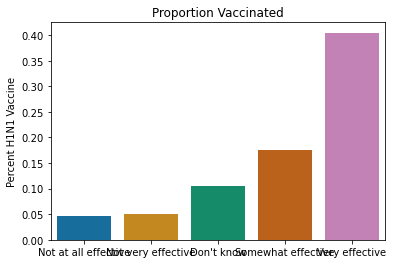

In [72]:
# Visualize proportion of level of respons opinion about seasonal flu vaccine effectiveness with H1N1 vaccination

fig, ax = plt.subplots()

sns.barplot(x=h1n1_rates_op_effective.index, y=h1n1_rates_op_effective.values)

ax.set_xlabel('')
ax.set_ylabel('Percent H1N1 Vaccine')
ax.set_title('Proportion Vaccinated')

ax.set_xticklabels(['Not at all effective', 'Not very effective', "Don't know", 'Somewhat effective', 'Very effective'])

[Text(0, 0, 'No Doc Recomendation'), Text(1, 0, 'Doc Recomendation')]

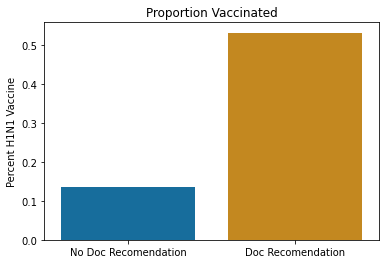

In [69]:
# Visualize proportion of no doc recomended and doc recomended with H1N1 vaccination

fig, ax = plt.subplots()

sns.barplot(x=h1n1_rates_docrec.index, y=h1n1_rates_docrec.values)

ax.set_xlabel('')
ax.set_ylabel('Percent H1N1 Vaccine')
ax.set_title('Proportion Vaccinated')

ax.set_xticklabels(['No Doc Recomendation', 'Doc Recomendation'])

[Text(0, 0, 'Not Health Worker'), Text(1, 0, 'Health Worker')]

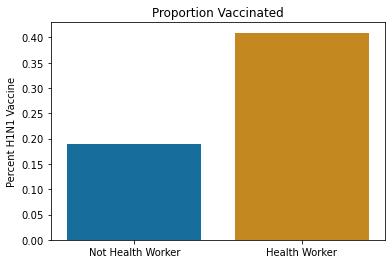

In [68]:
# Visualize proportion of not health care worker and health care worker with H1N1 vaccination

fig, ax = plt.subplots()

sns.barplot(x=h1n1_rates_healthworker.index, y=h1n1_rates_healthworker.values)

ax.set_xlabel('')
ax.set_ylabel('Percent H1N1 Vaccine')
ax.set_title('Proportion Vaccinated')

ax.set_xticklabels(['Not Health Worker', 'Health Worker'])

In [ ]:
df_exp = df.drop(['respondent_id', 'respondent_id_tars'], axis=1)

In [ ]:
for column in df.select_dtypes(include='object'):
    columnSeriesObj = df.select_dtypes(include='object')[column]
    print(column,': \n', columnSeriesObj.value_counts(), '\n \n',
         columnSeriesObj.value_counts(normalize=True), '\n')

In [ ]:
df.shape

In [91]:
X = df.drop(['respondent_id', 'respondent_id_tars',
            'h1n1_vaccine', 'seasonal_vaccine'], axis=1)
y = df.h1n1_vaccine

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42)

In [92]:
print(X_train.shape)
print(y_train.shape)

(20030, 35)
(20030,)


In [87]:
# Numeric Pipeline

num_pipe = Pipeline([
    ('num_impute', SimpleImputer(strategy='mean'))
])

# Categorical Pipeline

cat_pipe = Pipeline([
    ('cat_impute', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

# Ordinal Pipeline
ord_pipe = Pipeline([
    ('ord_imputer', SimpleImputer(strategy='most_frequent')),
    ('ord_enc', OrdinalEncoder())
])

In [88]:
CT = ColumnTransformer([
    ('num_trans', num_pipe, selector(dtype_include=np.number)),
    ('cat_trans', cat_pipe, selector(dtype_include=object)),
], remainder='passthrough')

In [89]:
class ModelWithCV():
    '''Structure to save the model and more easily see its crossvalidation'''
    
    def __init__(self, model, model_name, X, y, cv_now=True):
        self.model = model
        self.name = model_name
        self.X = X
        self.y = y
        # For CV results
        self.cv_results = None
        self.cv_mean = None
        self.cv_median = None
        self.cv_std = None
        #
        if cv_now:
            self.cross_validate()
        
    def cross_validate(self, X=None, y=None, kfolds=10):
        '''
        Perform cross-validation and return results.
        
        Args: 
          X:
            Optional; Training data to perform CV on. Otherwise use X from object
          y:
            Optional; Training data to perform CV on. Otherwise use y from object
          kfolds:
            Optional; Number of folds for CV (default is 10)  
        '''
        
        cv_X = X if X else self.X
        cv_y = y if y else self.y

        self.cv_results = cross_val_score(self.model, cv_X, cv_y, cv=kfolds)
        self.cv_mean = np.mean(self.cv_results)
        self.cv_median = np.median(self.cv_results)
        self.cv_std = np.std(self.cv_results)

        
    def print_cv_summary(self):
        cv_summary = (
        f'''CV Results for `{self.name}` model:
            {self.cv_mean:.5f} ± {self.cv_std:.5f} accuracy
        ''')
        print(cv_summary)

        
    def plot_cv(self, ax):
        '''
        Plot the cross-validation values using the array of results and given 
        Axis for plotting.
        '''
        ax.set_title(f'CV Results for `{self.name}` Model')
        # Thinner violinplot with higher bw
        sns.violinplot(y=self.cv_results, ax=ax, bw=.4)
        sns.swarmplot(
                y=self.cv_results,
                color='orange',
                size=10,
                alpha= 0.8,
                ax=ax
        )

        return ax

In [90]:
# Create Dummy/Baseline

dummy_model = Pipeline([
    ('ct', CT),
    ('dummy', DummyClassifier(strategy='most_frequent'))
])

In [93]:
# Use the class with our dummy pipe

dummy_model_pipe = ModelWithCV(dummy_model, model_name='dummy', X=X_train, y=y_train)

In [94]:

dummy_model_pipe.print_cv_summary()

CV Results for `dummy` model:
            0.78747 ± 0.00023 accuracy
        


In [96]:
dummy_model_pipe.cv_mean

0.7874687968047928

In [97]:
# Use the class with out logreg pipe

logreg_fsm = Pipeline([
    ('ct', CT),
    ('logreg_fsm', LogisticRegression(random_state=42, max_iter=1000))
])

In [98]:
fsm_model_pipe = ModelWithCV(logreg_fsm, model_name='fsm', X=X_train, y=y_train)

In [99]:
fsm_model_pipe.print_cv_summary()

CV Results for `fsm` model:
            0.83505 ± 0.00580 accuracy
        


<AxesSubplot:title={'center':'CV Results for `fsm` Model'}>

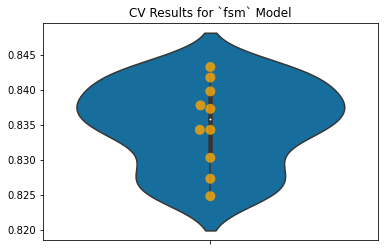

In [100]:
fig,ax = plt.subplots()

fsm_model_pipe.plot_cv(ax=ax)

In [113]:
X_clean = df.loc[:, ['opinion_h1n1_risk', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_sick_from_vacc',
                 'doctor_recc_h1n1', 'health_worker', 'h1n1_concern',
                    'employment_industry', 'employment_occupation']]

y = df.h1n1_vaccine

X_clean_train, X_clean_test, y_clean_train, y_clean_test = train_test_split(X_clean,y,random_state=42)

In [114]:
f_clean_model_pipe = ModelWithCV(logreg_fsm, model_name='fsm', X=X_clean_train, y=y_clean_train)

In [115]:
f_clean_model_pipe.print_cv_summary()

CV Results for `fsm` model:
            0.82906 ± 0.00492 accuracy
        


In [ ]:
# rfc!

# rfc = RandomForestClassifier(random_state=42)

# rfc_model_pipe = ImPipeline([
#     ('ct', CT),
#     ('sm', SMOTE(random_state=42)),
#     ('rfc', rfc)])

# forest_pipe = ModelWithCV(model=rfc_model_pipe,
#                           model_name='forest_pipe',
#                           X=X_train,
#                           y=y_train)

# fig, ax = plt.subplots()

# forest_pipe.plot_cv(ax=ax);

In [116]:
# forest_pipe.print_cv_summary()

In [117]:
# Logistic Regression

lr = LogisticRegression(random_state=42)

lr_model_pipe = ImPipeline([
    ('ct', CT),
    ('sm', SMOTE(random_state=42)),
    ('lr', lr)
])

lr_params = {
    'ct__num_trans__num_impute__strategy' : ['mean', 'median'],
    'lr__penalty' : ['l1', 'l2', 'elasticnet'],
    'lr__solver' : ['lbfgs', 'liblinear', 'saga'],
    'lr__max_iter' : [100, 1000, 5000]
}


# Random Forest Classsifier

rfc = RandomForestClassifier(random_state=42)

rfc_model_pipe = ImPipeline([
    ('ct', CT),
    ('sm', SMOTE(random_state=42)),
    ('rfc', rfc)])

rfc_params = {
    'ct__num_trans__num_impute__strategy' : ['mean', 'median'],
    'rfc__criterion' : ['gini', 'entropy', 'log_loss'],
    'rfc__max_depth' : [11, 13, 15, 17],
    'rfc__min_samples_leaf' : [1, 5, 15, 25, 50, 75, 100]
}

# K-Nearest Neighbors Classifier

knn = KNeighborsClassifier()

knn_model_pipe = ImPipeline([
    ('ct', CT),
    ('sm', SMOTE(random_state=42)),
    ('knn', knn)])

knn_params = {
    'ct__num_trans__num_impute__strategy' : ['mean', 'median'],
    'knn__n_neighbors' : [1, 3, 5, 7, 9, 11],
    'knn__weights' : ['uniform', 'distance'],
    'knn__leaf_size' : [20, 30, 40],
    'knn__metric' : ['minkowski', 'cityblock']
}

In [ ]:
gs_lr = GridSearchCV(estimator=lr_model_pipe, param_grid=lr_params, cv=10, verbose=2)

gs_lr.fit(X_train, y_train)

Fitting 10 folds for each of 54 candidates, totalling 540 fits
[CV] ct__num_trans__num_impute__strategy=mean, lr__max_iter=100, lr__penalty=l1, lr__solver=lbfgs 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_so

[CV]  ct__num_trans__num_impute__strategy=mean, lr__max_iter=100, lr__penalty=l1, lr__solver=lbfgs, total=   2.5s
[CV] ct__num_trans__num_impute__strategy=mean, lr__max_iter=100, lr__penalty=l1, lr__solver=lbfgs 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

[CV]  ct__num_trans__num_impute__strategy=mean, lr__max_iter=100, lr__penalty=l1, lr__solver=lbfgs, total=   2.3s
[CV] ct__num_trans__num_impute__strategy=mean, lr__max_iter=100, lr__penalty=l1, lr__solver=lbfgs 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

[CV]  ct__num_trans__num_impute__strategy=mean, lr__max_iter=100, lr__penalty=l1, lr__solver=lbfgs, total=   2.4s
[CV] ct__num_trans__num_impute__strategy=mean, lr__max_iter=100, lr__penalty=l1, lr__solver=lbfgs 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

[CV]  ct__num_trans__num_impute__strategy=mean, lr__max_iter=100, lr__penalty=l1, lr__solver=lbfgs, total=   2.5s
[CV] ct__num_trans__num_impute__strategy=mean, lr__max_iter=100, lr__penalty=l1, lr__solver=lbfgs 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

[CV]  ct__num_trans__num_impute__strategy=mean, lr__max_iter=100, lr__penalty=l1, lr__solver=lbfgs, total=   2.4s
[CV] ct__num_trans__num_impute__strategy=mean, lr__max_iter=100, lr__penalty=l1, lr__solver=lbfgs 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

[CV]  ct__num_trans__num_impute__strategy=mean, lr__max_iter=100, lr__penalty=l1, lr__solver=lbfgs, total=   2.3s
[CV] ct__num_trans__num_impute__strategy=mean, lr__max_iter=100, lr__penalty=l1, lr__solver=lbfgs 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

[CV]  ct__num_trans__num_impute__strategy=mean, lr__max_iter=100, lr__penalty=l1, lr__solver=lbfgs, total=   2.5s
[CV] ct__num_trans__num_impute__strategy=mean, lr__max_iter=100, lr__penalty=l1, lr__solver=lbfgs 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

[CV]  ct__num_trans__num_impute__strategy=mean, lr__max_iter=100, lr__penalty=l1, lr__solver=lbfgs, total=   2.4s
[CV] ct__num_trans__num_impute__strategy=mean, lr__max_iter=100, lr__penalty=l1, lr__solver=lbfgs 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

[CV]  ct__num_trans__num_impute__strategy=mean, lr__max_iter=100, lr__penalty=l1, lr__solver=lbfgs, total=   2.3s
[CV] ct__num_trans__num_impute__strategy=mean, lr__max_iter=100, lr__penalty=l1, lr__solver=lbfgs 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

[CV]  ct__num_trans__num_impute__strategy=mean, lr__max_iter=100, lr__penalty=l1, lr__solver=lbfgs, total=   2.3s
[CV] ct__num_trans__num_impute__strategy=mean, lr__max_iter=100, lr__penalty=l1, lr__solver=liblinear 
[CV]  ct__num_trans__num_impute__strategy=mean, lr__max_iter=100, lr__penalty=l1, lr__solver=liblinear, total=  17.5s
[CV] ct__num_trans__num_impute__strategy=mean, lr__max_iter=100, lr__penalty=l1, lr__solver=liblinear 
[CV]  ct__num_trans__num_impute__strategy=mean, lr__max_iter=100, lr__penalty=l1, lr__solver=liblinear, total=  45.6s
[CV] ct__num_trans__num_impute__strategy=mean, lr__max_iter=100, lr__penalty=l1, lr__solver=liblinear 
[CV]  ct__num_trans__num_impute__strategy=mean, lr__max_iter=100, lr__penalty=l1, lr__solver=liblinear, total=  42.7s
[CV] ct__num_trans__num_impute__strategy=mean, lr__max_iter=100, lr__penalty=l1, lr__solver=liblinear 
[CV]  ct__num_trans__num_impute__strategy=mean, lr__max_iter=100, lr__penalty=l1, lr__solver=liblinear, total=  41.7s
[C

C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  ct__num_trans__num_impute__strategy=mean, lr__max_iter=100, lr__penalty=l1, lr__solver=saga, total=   5.8s
[CV] ct__num_trans__num_impute__strategy=mean, lr__max_iter=100, lr__penalty=l1, lr__solver=saga 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  ct__num_trans__num_impute__strategy=mean, lr__max_iter=100, lr__penalty=l1, lr__solver=saga, total=   5.9s
[CV] ct__num_trans__num_impute__strategy=mean, lr__max_iter=100, lr__penalty=l1, lr__solver=saga 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  ct__num_trans__num_impute__strategy=mean, lr__max_iter=100, lr__penalty=l1, lr__solver=saga, total=   5.8s
[CV] ct__num_trans__num_impute__strategy=mean, lr__max_iter=100, lr__penalty=l1, lr__solver=saga 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  ct__num_trans__num_impute__strategy=mean, lr__max_iter=100, lr__penalty=l1, lr__solver=saga, total=   5.8s
[CV] ct__num_trans__num_impute__strategy=mean, lr__max_iter=100, lr__penalty=l1, lr__solver=saga 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  ct__num_trans__num_impute__strategy=mean, lr__max_iter=100, lr__penalty=l1, lr__solver=saga, total=   5.8s
[CV] ct__num_trans__num_impute__strategy=mean, lr__max_iter=100, lr__penalty=l1, lr__solver=saga 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  ct__num_trans__num_impute__strategy=mean, lr__max_iter=100, lr__penalty=l1, lr__solver=saga, total=   5.8s
[CV] ct__num_trans__num_impute__strategy=mean, lr__max_iter=100, lr__penalty=l1, lr__solver=saga 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  ct__num_trans__num_impute__strategy=mean, lr__max_iter=100, lr__penalty=l1, lr__solver=saga, total=   5.9s
[CV] ct__num_trans__num_impute__strategy=mean, lr__max_iter=100, lr__penalty=l1, lr__solver=saga 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  ct__num_trans__num_impute__strategy=mean, lr__max_iter=100, lr__penalty=l1, lr__solver=saga, total=   5.9s
[CV] ct__num_trans__num_impute__strategy=mean, lr__max_iter=100, lr__penalty=l1, lr__solver=saga 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  ct__num_trans__num_impute__strategy=mean, lr__max_iter=100, lr__penalty=l1, lr__solver=saga, total=   6.3s
[CV] ct__num_trans__num_impute__strategy=mean, lr__max_iter=100, lr__penalty=l1, lr__solver=saga 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  ct__num_trans__num_impute__strategy=mean, lr__max_iter=100, lr__penalty=l1, lr__solver=saga, total=   5.8s
[CV] ct__num_trans__num_impute__strategy=mean, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV]  ct__num_trans__num_impute__strategy=mean, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=mean, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV]  ct__num_trans__num_impute__strategy=mean, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs, total=   2.8s
[CV] ct__num_trans__num_impute__strategy=mean, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV]  ct__num_trans__num_impute__strategy=mean, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs, total=   2.8s
[CV] ct__num_trans__num_impute__strategy=mean, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV]  ct__num_trans__num_impute__strategy=mean, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs, total=   2.8s
[CV] ct__num_trans__num_impute__strategy=mean, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV]  ct__num_trans__num_impute__strategy=mean, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=mean, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV]  ct__num_trans__num_impute__strategy=mean, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs, total=   2.8s
[CV] ct__num_trans__num_impute__strategy=mean, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV]  ct__num_trans__num_impute__strategy=mean, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs, total=   2.8s
[CV] ct__num_trans__num_impute__strategy=mean, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV]  ct__num_trans__num_impute__strategy=mean, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=mean, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV]  ct__num_trans__num_impute__strategy=mean, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=mean, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV]  ct__num_trans__num_impute__strategy=mean, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs, total=   2.8s
[CV] ct__num_trans__num_impute__strategy=mean, lr__max_iter=100, lr__penalty=l2, lr__solver=liblinear 
[CV]  ct__num_trans__num_impute__strategy=mean, lr__max_iter=100, lr__penalty=l2, lr__solver=liblinear, total=   2.6s
[CV] ct__num_trans__num_impute__strategy=mean, lr__max_iter=100, lr__penalty=l2, lr__solver=liblinear 
[CV]  ct__num_trans__num_impute__strategy=mean, lr__max_iter=100, lr__penalty=l2, lr__solver=liblinear, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=mean, lr__max_iter=100, lr__penalty=l2, lr__solver=liblinear 
[CV]  ct__num_trans__num_impute__strategy=mean, lr__max_iter=100, lr__penalty=l2, lr__solver=liblinear, total=   2.6s
[CV] ct__num_trans__num_impute__strategy=mean, lr__max_iter=100, lr__penalty=l2, lr__solver=liblinear 
[CV]  ct__num_trans__num_impute__strategy=mean, lr__max_iter=100, lr__penalty=l2, lr__solver=liblinear, total=   2.7s
[C

C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  ct__num_trans__num_impute__strategy=mean, lr__max_iter=100, lr__penalty=l2, lr__solver=saga, total=   5.9s
[CV] ct__num_trans__num_impute__strategy=mean, lr__max_iter=100, lr__penalty=l2, lr__solver=saga 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  ct__num_trans__num_impute__strategy=mean, lr__max_iter=100, lr__penalty=l2, lr__solver=saga, total=   5.8s
[CV] ct__num_trans__num_impute__strategy=mean, lr__max_iter=100, lr__penalty=l2, lr__solver=saga 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  ct__num_trans__num_impute__strategy=mean, lr__max_iter=100, lr__penalty=l2, lr__solver=saga, total=   5.8s
[CV] ct__num_trans__num_impute__strategy=mean, lr__max_iter=100, lr__penalty=l2, lr__solver=saga 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  ct__num_trans__num_impute__strategy=mean, lr__max_iter=100, lr__penalty=l2, lr__solver=saga, total=   5.8s
[CV] ct__num_trans__num_impute__strategy=mean, lr__max_iter=100, lr__penalty=l2, lr__solver=saga 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  ct__num_trans__num_impute__strategy=mean, lr__max_iter=100, lr__penalty=l2, lr__solver=saga, total=   5.8s
[CV] ct__num_trans__num_impute__strategy=mean, lr__max_iter=100, lr__penalty=l2, lr__solver=saga 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  ct__num_trans__num_impute__strategy=mean, lr__max_iter=100, lr__penalty=l2, lr__solver=saga, total=   5.8s
[CV] ct__num_trans__num_impute__strategy=mean, lr__max_iter=100, lr__penalty=l2, lr__solver=saga 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  ct__num_trans__num_impute__strategy=mean, lr__max_iter=100, lr__penalty=l2, lr__solver=saga, total=   5.8s
[CV] ct__num_trans__num_impute__strategy=mean, lr__max_iter=100, lr__penalty=l2, lr__solver=saga 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  ct__num_trans__num_impute__strategy=mean, lr__max_iter=100, lr__penalty=l2, lr__solver=saga, total=   5.9s
[CV] ct__num_trans__num_impute__strategy=mean, lr__max_iter=100, lr__penalty=l2, lr__solver=saga 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  ct__num_trans__num_impute__strategy=mean, lr__max_iter=100, lr__penalty=l2, lr__solver=saga, total=   6.3s
[CV] ct__num_trans__num_impute__strategy=mean, lr__max_iter=100, lr__penalty=l2, lr__solver=saga 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  ct__num_trans__num_impute__strategy=mean, lr__max_iter=100, lr__penalty=l2, lr__solver=saga, total=   6.5s
[CV] ct__num_trans__num_impute__strategy=mean, lr__max_iter=100, lr__penalty=elasticnet, lr__solver=lbfgs 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

[CV]  ct__num_trans__num_impute__strategy=mean, lr__max_iter=100, lr__penalty=elasticnet, lr__solver=lbfgs, total=   2.5s
[CV] ct__num_trans__num_impute__strategy=mean, lr__max_iter=100, lr__penalty=elasticnet, lr__solver=lbfgs 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

[CV]  ct__num_trans__num_impute__strategy=mean, lr__max_iter=100, lr__penalty=elasticnet, lr__solver=lbfgs, total=   2.4s
[CV] ct__num_trans__num_impute__strategy=mean, lr__max_iter=100, lr__penalty=elasticnet, lr__solver=lbfgs 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

[CV]  ct__num_trans__num_impute__strategy=mean, lr__max_iter=100, lr__penalty=elasticnet, lr__solver=lbfgs, total=   2.4s
[CV] ct__num_trans__num_impute__strategy=mean, lr__max_iter=100, lr__penalty=elasticnet, lr__solver=lbfgs 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

[CV]  ct__num_trans__num_impute__strategy=mean, lr__max_iter=100, lr__penalty=elasticnet, lr__solver=lbfgs, total=   2.4s
[CV] ct__num_trans__num_impute__strategy=mean, lr__max_iter=100, lr__penalty=elasticnet, lr__solver=lbfgs 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

[CV]  ct__num_trans__num_impute__strategy=mean, lr__max_iter=100, lr__penalty=elasticnet, lr__solver=lbfgs, total=   2.3s
[CV] ct__num_trans__num_impute__strategy=mean, lr__max_iter=100, lr__penalty=elasticnet, lr__solver=lbfgs 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

[CV]  ct__num_trans__num_impute__strategy=mean, lr__max_iter=100, lr__penalty=elasticnet, lr__solver=lbfgs, total=   2.4s
[CV] ct__num_trans__num_impute__strategy=mean, lr__max_iter=100, lr__penalty=elasticnet, lr__solver=lbfgs 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

[CV]  ct__num_trans__num_impute__strategy=mean, lr__max_iter=100, lr__penalty=elasticnet, lr__solver=lbfgs, total=   2.4s
[CV] ct__num_trans__num_impute__strategy=mean, lr__max_iter=100, lr__penalty=elasticnet, lr__solver=lbfgs 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

[CV]  ct__num_trans__num_impute__strategy=mean, lr__max_iter=100, lr__penalty=elasticnet, lr__solver=lbfgs, total=   2.3s
[CV] ct__num_trans__num_impute__strategy=mean, lr__max_iter=100, lr__penalty=elasticnet, lr__solver=lbfgs 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

[CV]  ct__num_trans__num_impute__strategy=mean, lr__max_iter=100, lr__penalty=elasticnet, lr__solver=lbfgs, total=   2.4s
[CV] ct__num_trans__num_impute__strategy=mean, lr__max_iter=100, lr__penalty=elasticnet, lr__solver=lbfgs 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

[CV]  ct__num_trans__num_impute__strategy=mean, lr__max_iter=100, lr__penalty=elasticnet, lr__solver=lbfgs, total=   2.3s
[CV] ct__num_trans__num_impute__strategy=mean, lr__max_iter=100, lr__penalty=elasticnet, lr__solver=liblinear 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 449, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
Value

[CV]  ct__num_trans__num_impute__strategy=mean, lr__max_iter=100, lr__penalty=elasticnet, lr__solver=liblinear, total=   2.3s
[CV] ct__num_trans__num_impute__strategy=mean, lr__max_iter=100, lr__penalty=elasticnet, lr__solver=liblinear 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 449, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
Value

[CV]  ct__num_trans__num_impute__strategy=mean, lr__max_iter=100, lr__penalty=elasticnet, lr__solver=liblinear, total=   2.3s
[CV] ct__num_trans__num_impute__strategy=mean, lr__max_iter=100, lr__penalty=elasticnet, lr__solver=liblinear 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 449, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
Value

[CV]  ct__num_trans__num_impute__strategy=mean, lr__max_iter=100, lr__penalty=elasticnet, lr__solver=liblinear, total=   2.3s
[CV] ct__num_trans__num_impute__strategy=mean, lr__max_iter=100, lr__penalty=elasticnet, lr__solver=liblinear 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 449, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
Value

[CV]  ct__num_trans__num_impute__strategy=mean, lr__max_iter=100, lr__penalty=elasticnet, lr__solver=liblinear, total=   2.3s
[CV] ct__num_trans__num_impute__strategy=mean, lr__max_iter=100, lr__penalty=elasticnet, lr__solver=liblinear 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 449, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
Value

[CV]  ct__num_trans__num_impute__strategy=mean, lr__max_iter=100, lr__penalty=elasticnet, lr__solver=liblinear, total=   2.3s
[CV] ct__num_trans__num_impute__strategy=mean, lr__max_iter=100, lr__penalty=elasticnet, lr__solver=liblinear 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 449, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
Value

[CV]  ct__num_trans__num_impute__strategy=mean, lr__max_iter=100, lr__penalty=elasticnet, lr__solver=liblinear, total=   2.4s
[CV] ct__num_trans__num_impute__strategy=mean, lr__max_iter=100, lr__penalty=elasticnet, lr__solver=liblinear 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 449, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
Value

[CV]  ct__num_trans__num_impute__strategy=mean, lr__max_iter=100, lr__penalty=elasticnet, lr__solver=liblinear, total=   2.3s
[CV] ct__num_trans__num_impute__strategy=mean, lr__max_iter=100, lr__penalty=elasticnet, lr__solver=liblinear 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 449, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
Value

[CV]  ct__num_trans__num_impute__strategy=mean, lr__max_iter=100, lr__penalty=elasticnet, lr__solver=liblinear, total=   2.4s
[CV] ct__num_trans__num_impute__strategy=mean, lr__max_iter=100, lr__penalty=elasticnet, lr__solver=liblinear 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 449, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
Value

[CV]  ct__num_trans__num_impute__strategy=mean, lr__max_iter=100, lr__penalty=elasticnet, lr__solver=liblinear, total=   2.4s
[CV] ct__num_trans__num_impute__strategy=mean, lr__max_iter=100, lr__penalty=elasticnet, lr__solver=liblinear 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 449, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
Value

[CV]  ct__num_trans__num_impute__strategy=mean, lr__max_iter=100, lr__penalty=elasticnet, lr__solver=liblinear, total=   2.3s
[CV] ct__num_trans__num_impute__strategy=mean, lr__max_iter=100, lr__penalty=elasticnet, lr__solver=saga 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1312, in fit
    raise ValueError("l1_ratio must be between 0 and 1;"
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  ct__num_trans__num_impute__strategy=mean, lr__max_iter=100, lr__penalty=elasticnet, lr__solver=saga, total=   2.3s
[CV] ct__num_trans__num_impute__strategy=mean, lr__max_iter=100, lr__penalty=elasticnet, lr__solver=saga 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1312, in fit
    raise ValueError("l1_ratio must be between 0 and 1;"
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  ct__num_trans__num_impute__strategy=mean, lr__max_iter=100, lr__penalty=elasticnet, lr__solver=saga, total=   2.4s
[CV] ct__num_trans__num_impute__strategy=mean, lr__max_iter=100, lr__penalty=elasticnet, lr__solver=saga 


In [ ]:
gs_lr.best_params_

In [ ]:
gs_lr.best_score_

In [ ]:
gs_lr.best_estimator_.score(X_test, y_test)

In [ ]:
gs_rfm = GridSearchCV(estimator=rfc_model_pipe, param_grid=rfc_params, cv=10, verbose=2)

gs_rfm.fit(X_train, y_train)

In [ ]:
gs_rfm.best_params_

In [ ]:
gs_rfm.best_score_

In [ ]:
gs_rfm.best_estimator_.score(X_test, y_test)

In [ ]:
gs_knn = GridSearchCV(estimator=knn_model_pipe, param_grid=knn_params, cv=10, verbose=2)

gs_knn.fit(X_train, y_train)

In [ ]:
gs_knn.best_params_

In [ ]:
gs_knn.best_score_

In [ ]:
gs_knn.best_estimator_.score(X_test, y_test)

In [ ]:
rfc_params = {
    'ct__num_trans__num_impute__strategy' : ['mean', 'median'],
    'rfc__criterion' : ['gini', 'entropy', 'log_loss'],
    'rfc__max_depth' : [11, 13, 15, 17],
    'rfc__min_samples_leaf' : [1, 5, 15, 25, 50, 75, 100]
}

gs = GridSearchCV(estimator=rfc_model_pipe, param_grid=rfc_params, cv=10, verbose=2)

gs.fit(X_train, y_train)

In [ ]:
gs.best_params_

In [ ]:
gs.best_score_

In [ ]:
gs.best_estimator_.score(X_test, y_test)